In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision as vision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
import tarfile

In [44]:
ds=CIFAR10(root="data/",download=True,transform=transforms.ToTensor(),train=True)

Files already downloaded and verified


torch.Size([3, 32, 32])


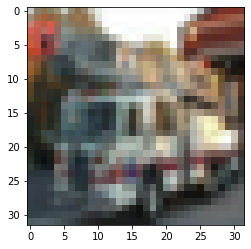

In [50]:
i,j=ds[900]
print(i.shape)
plt.imshow(i.permute(1,2,0))


In [55]:
j

tensor([[[0.7686, 0.5333, 0.5608,  ..., 0.4941, 0.4941, 0.4941],
         [0.6039, 0.6000, 0.6471,  ..., 0.5961, 0.6196, 0.6078],
         [0.7686, 0.7725, 0.7137,  ..., 0.5686, 0.5294, 0.4863],
         ...,
         [0.1961, 0.1922, 0.1804,  ..., 0.4000, 0.4157, 0.4078],
         [0.2039, 0.2078, 0.2196,  ..., 0.4039, 0.4078, 0.4078],
         [0.3059, 0.3216, 0.3294,  ..., 0.3765, 0.3647, 0.3765]],

        [[0.7608, 0.4941, 0.4471,  ..., 0.1961, 0.2000, 0.2157],
         [0.5569, 0.4353, 0.3725,  ..., 0.3333, 0.3647, 0.3843],
         [0.5137, 0.3961, 0.3647,  ..., 0.3686, 0.3294, 0.3059],
         ...,
         [0.2431, 0.2392, 0.2275,  ..., 0.4078, 0.4196, 0.4078],
         [0.2549, 0.2588, 0.2706,  ..., 0.4275, 0.4275, 0.4157],
         [0.3569, 0.3725, 0.3804,  ..., 0.4118, 0.4000, 0.4000]],

        [[0.7373, 0.4118, 0.3098,  ..., 0.1529, 0.1529, 0.1608],
         [0.4784, 0.3020, 0.2275,  ..., 0.2588, 0.2902, 0.3137],
         [0.4588, 0.3176, 0.2784,  ..., 0.2941, 0.2588, 0.

In [7]:
dl=DataLoader(ds,batch_size=90,shuffle=True)

In [58]:
ds.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']